In [2]:
import os
import numpy as np
import pandas as pd
import glob
import math

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#image imports
import imageio

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, EfficientNetB5
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# utils
from IPython.display import clear_output

### Labels used in the process
* Out of 19 only 12 labes or interest are used and defined here

In [2]:
label_to_name = {
    0: "Nucleoplasm",
    1: "Nucleoli",
    2: "Nucleoli fibrillar center",
    3: "Nuclear speckles",
    4: "Nuclear bodies",
    5: "Endoplasmic reticulum",
    6: "Golgi apparatus",
    7: "Intermediate filaments",
    8: "Centrosome",
    9: "Plasma membrane",
    10: "Mitochondria",
    11: "Cytosol"
}

name_label = {
    "Nucleoplasm":0,
    "Nucleoli":1,
    "Nucleoli fibrillar center":2,
    "Nuclear speckles":3,
    "Nuclear bodies":4,
    "Endoplasmic reticulum":5,
    "Golgi apparatus":6,
    "Intermediate filaments":7,
    "Centrosome":8,
    "Plasma membrane":9,
    "Mitochondria":10,
    "Cytosol":11
}

### Constants used for modeling
* Each folder has files for all the 12 classes outlined abouve.

In [3]:
#IMAGE_SIZE = [456,456] #B5 Efficinet Model
#IMAGE_SIZE = [600,600] #B7 Efficinet Model
IMAGE_SIZE = [528,528] #B6 Efficinet Model

train_path = 'data/flow/train'
validation_path = 'data/flow/validation'
test_path = 'data/flow/test'
batch_size = 7
label_count = 12

In [4]:
## TBD -- outline how many samples in each class label..

### Geenrators for the train, validation and test
* To train models, keras image generator and images from `labels` directories are used
* Image files are created in the folders such a way that keras `ImageDataGenerator` and `flow_from_directory` utils can be used to read and feed them to neural network

In [21]:
# image generator for train and validation.
# For trainin and test image manipulation parameters are defined as below
gen = ImageDataGenerator(
  rotation_range=40,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.3,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

# Test generator, feed the images as is
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [22]:
# create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    seed=777
)
valid_generator = gen.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
    seed=888
)

test_gen = test_gen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    shuffle=False,
    batch_size=batch_size
)

Found 113780 images belonging to 12 classes.
Found 28445 images belonging to 12 classes.
Found 9482 images belonging to 12 classes.


## Define model

In [44]:
# effnet = EfficientNetB6(
#     input_shape=[528,528, 3], 
#     include_top=False, 
#     weights='imagenet')
# x = GlobalAveragePooling2D ()(effnet.output)
# x = Dense(folders, activation='softmax')(x)
# effnet_model = Model(effnet.input, x)
# #model.summary()

In [45]:
# opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001, amsgrad=True)
# opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.2)
# opt_nadam = tf.keras.optimizers.Nadam(learning_rate=0.000001,beta_1=0.9, beta_2=0.999)
# effnet_model.compile(loss='categorical_crossentropy', optimizer=opt_sgd, metrics=['accuracy'])

## Load saved model

In [3]:
effnet_model = tf.keras.models.load_model('saved-model/effnet-b6-nadam/', compile=False)

In [47]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.0000001, amsgrad=True)
opt = tf.keras.optimizers.Nadam(learning_rate=0.000001,beta_1=0.9, beta_2=0.999)
effnet_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [4]:
effnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 528, 528, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 528, 528, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 528, 528, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 529, 529, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

## Train and validate model

In [19]:
# Un comment and run to run model from scratch or continue running from previous
# for iteration in range(1):
#     clear_output(wait=True)
#     print(f'Iteration:{iteration}')
#     r = effnet_model.fit_generator(
#       train_generator,
#       validation_data=valid_generator,
#       epochs=5,
#       steps_per_epoch=150,
#       validation_steps=10,
#     )
#     if(iteration+1) % 2 == 0:
#         effnet_model.save('effnet_model-b7-single-generator-model')

Iteration:0
Epoch 1/5
150/150 [==============================] - 206s 1s/step - loss: 0.9682 - accuracy: 0.6830 - val_loss: 1.1723 - val_accuracy: 0.6286
Epoch 2/5
150/150 [==============================] - 169s 1s/step - loss: 1.0178 - accuracy: 0.6659 - val_loss: 0.9935 - val_accuracy: 0.6286
Epoch 3/5
150/150 [==============================] - 166s 1s/step - loss: 0.9623 - accuracy: 0.6674 - val_loss: 0.9367 - val_accuracy: 0.6857
Epoch 4/5
150/150 [==============================] - 166s 1s/step - loss: 0.9617 - accuracy: 0.6832 - val_loss: 0.8786 - val_accuracy: 0.7143
Epoch 5/5
150/150 [==============================] - 166s 1s/step - loss: 0.9077 - accuracy: 0.7008 - val_loss: 0.9621 - val_accuracy: 0.6714


## Test set validation

In [14]:
labels_from_generator = (test_gen.class_indices)
labels_from_generator = [k for k,v in labels_from_generator.items()]
test_gen.reset()
labels_from_generator

['Centrosome',
 'Cytosol',
 'Endoplasmic reticulum',
 'Golgi apparatus',
 'Intermediate filaments',
 'Mitochondria',
 'Nuclear bodies',
 'Nuclear speckles',
 'Nucleoli',
 'Nucleoli fibrillar center',
 'Nucleoplasm',
 'Plasma membrane']

In [31]:
def get_confusion_matrix(model, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix. Total images to predict", N)
    predictions = []
    targets = []
    i = 0
    for x, y in test_gen:
        i += 1
        if i % 100 == 0:
            print(f'Finished predicting {i} batches')
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [34]:
%%time
test_gen.reset()
result = get_confusion_matrix( effnet_model,9482)

Generating confusion matrix. Total images to predict 9482
Finished predicting 100 batches
Finished predicting 200 batches
Finished predicting 300 batches
Finished predicting 400 batches
Finished predicting 500 batches
Finished predicting 600 batches
Finished predicting 700 batches
Finished predicting 800 batches
Finished predicting 900 batches
Finished predicting 1000 batches
Finished predicting 1100 batches
Finished predicting 1200 batches
Finished predicting 1300 batches
Wall time: 3min 55s


In [35]:
# print confusion matrix numbers
print(result)

[[ 347   29   10   20    9   20   33    3   14   10   50   25]
 [  67  626   69   29   19   31   17    2   11    5   62  111]
 [  19   90  261   11   11   54    2    2    3    3   15   29]
 [  58   27    5  501   14   37   13    9   12    8   36   18]
 [  19   18   16   24  321   23    5    1    1    2   14   25]
 [  37   44   42   71   14  884    3    7    3    9   53   30]
 [  80   17    1   20    5    8  303   19   11   20  110    5]
 [   8    5    3   10    3    5   20  594    6    6   87    8]
 [  35   14    0   15    4    1   12   10  328   23   28    8]
 [  27   10    1    7    5    3   44    8   18  301   25    7]
 [  57   34    8   21    4   17   36   78   18   13 1370   16]
 [  55  138   14   19   20   30    9    3    5   10   39  657]]


In [36]:
# Normalise to show percentages
cmn = result.astype('float') / result.sum(axis=1)[:, np.newaxis]

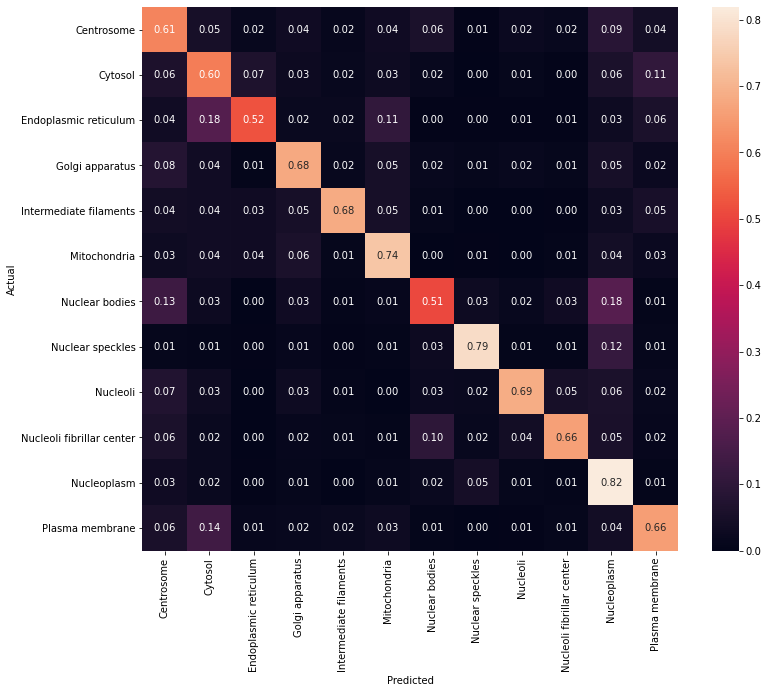

In [37]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=labels_from_generator, yticklabels=labels_from_generator)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

## Running from scratch to get losses

In [69]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

In [70]:
initial_learning_rate = 0.0001
def lr_step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 12.0
    return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

lr = LearningRateScheduler(lr_step_decay, verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1,restore_best_weights=True)
##cp = ModelCheckpoint(filepath='saved-model/checkpoint-b6', save_weights_only=False,monitor='val_accuracy', mode='max',save_best_only=True)

In [71]:
# model = EfficientNetB6(
#     input_shape=[528,528, 3], 
#     include_top=False, 
#     weights='imagenet')
# x = GlobalAveragePooling2D ()(model.output)
# x = Dense(label_count, activation='softmax')(x)
# model = Model(model.input, x)

In [108]:
##model.save('saved-model/checkpoint-b6/')

INFO:tensorflow:Assets written to: saved-model/checkpoint-b6/assets


In [72]:
# opt = tf.keras.optimizers.Nadam(learning_rate=0.000001,beta_1=0.8, beta_2=0.9)
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.00001, momentum=0.1)
# opt = tf.keras.optimizers.SGD(learning_rate=0.00001, momentum=0.1)
# opt = tf.keras.optimizers.Ftrl(learning_rate=0.001)
opt = tf.keras.optimizers.Adamax(learning_rate=0.0001)
model.compile(
    loss='categorical_crossentropy', 
    optimizer=opt, 
    metrics=['accuracy'])

In [107]:
res = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=225,
    validation_steps=35,
    callbacks=[lr,es]
)

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
225/225 [==============================] - 218s 966ms/step - loss: 1.4446 - accuracy: 0.5187 - val_loss: 1.4580 - val_accuracy: 0.5306
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0001.
225/225 [==============================] - 215s 954ms/step - loss: 1.4055 - accuracy: 0.5422 - val_loss: 1.2182 - val_accuracy: 0.5837
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0001.
225/225 [==============================] - 224s 995ms/step - loss: 1.3939 - accuracy: 0.5422 - val_loss: 1.4000 - val_accuracy: 0.5102
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0001.
225/225 [==============================] - 221s 981ms/step - loss: 1.3988 - accuracy: 0.5397 - val_loss: 1.4401 - val_accuracy: 0.5143
Epoch 5/10

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0001.
225/225 [==============================] - 222s 987ms/s

### Loss plots

In [101]:
# Load losses
pd_history1 = pd.read_csv('b6-history-first35.csv')
pd_history2  = pd.read_csv('b6-history-second-64.csv')
pd_history1 = pd_history1.append(pd_history2)
pd_history1 = pd_history1.reset_index()

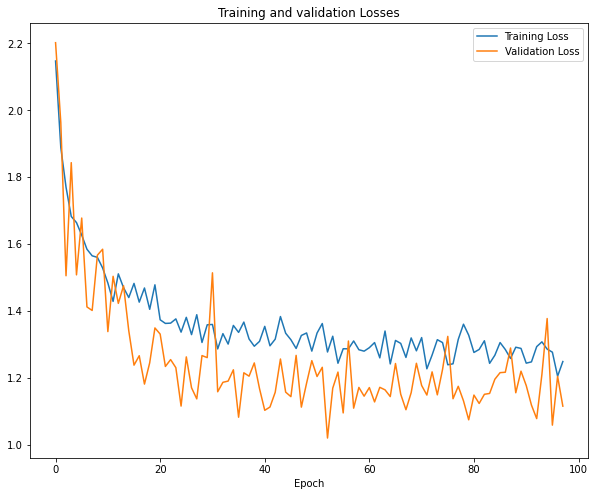

In [104]:
plt.figure(figsize=(10,8))
plt.plot(pd_history1['loss'], label='Training Loss')
plt.plot(pd_history1['val_loss'], label='Validation Loss')
plt.title('Training and validation Losses')
plt.xlabel('Epoch')
plt.legend()

### Accuracy plots

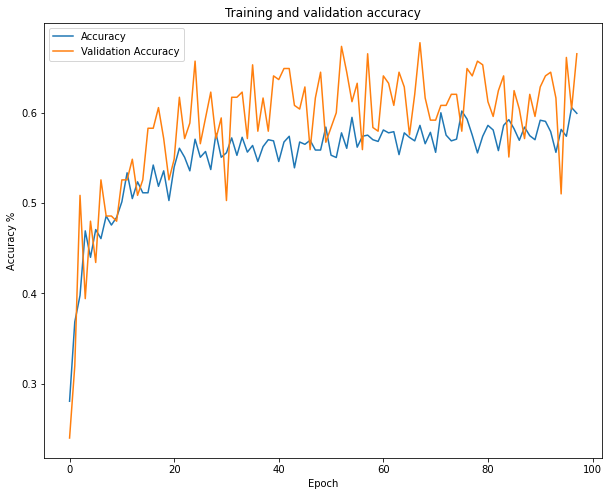

In [105]:
plt.figure(figsize=(10,8))
plt.plot(pd_history1['accuracy'], label='Accuracy')
plt.plot(pd_history1['val_accuracy'], label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()